In [1]:
## Every notebook should start with this header
# The next lines mean that changes in Python files are instantaneously applied
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from pathlib import Path

# As a sanity check, print out the current working directory
print(f"Running in {Path('').absolute()}")

import cfspopcon
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import xarray as xr
from cfspopcon.unit_handling import magnitude_in_units, ureg

import extended_lengyel
plt.style.use('paper_plots.mplstyle')

Running in /Users/tbody/Projects/extended-lengyel/notebooks


## Check that we can run the Lengyel model with different corrections switched on

We want to match the Kallenbach model with a 0D Lengyel model. How does this look as we try different terms?

In [2]:
def build_dataset(
    algorithm,
    **overrides
):
    algorithm = cfspopcon.Algorithm.get_algorithm(algorithm)
    
    ds = xr.Dataset(data_vars=extended_lengyel.read_config(
        elements        = ["base", "target_constraints"],
        keys            = algorithm.input_keys,
        allowed_missing = algorithm.default_keys,
        overrides       = overrides,
    ))

    algorithm.validate_inputs(ds)
    ds = algorithm.update_dataset(ds)
    
    return ds

reference_ds_firstpass    = build_dataset(algorithm="kallenbach_model")
spatial_lengyel_firstpass = build_dataset(algorithm="spatial_lengyel_model")

In [3]:
test_ds = build_dataset(
    algorithm                   = "basic_lengyel_model",
    q_parallel                  = reference_ds_firstpass["q_parallel"],
    separatrix_electron_density = reference_ds_firstpass["separatrix_electron_density"],
    z_effective                 = 1.0,
)

for key in [
    "SOL_momentum_loss_fraction",
    "SOL_power_loss_fraction",
    "separatrix_electron_temp",
    "impurity_fraction",
]:
    left1 = reference_ds_firstpass[key].item()
    left2 = spatial_lengyel_firstpass[key].item().to(left1.units)
    right = test_ds[key].item().to(left1.units)

    print(f"{key:40} {left1.magnitude:10.2g}, {left2.magnitude:10.2g} {right.magnitude:10.2g} {left1.units}")

SOL_momentum_loss_fraction                     0.51,       0.54       0.54 dimensionless
SOL_power_loss_fraction                        0.95,       0.96       0.96 dimensionless
separatrix_electron_temp                    1.3e+02,    1.4e+02    1.3e+02 electron_volt
impurity_fraction                                 4,          4         23 percent


In [4]:
test_ds = build_dataset(
    algorithm                   = "extended_lengyel_model_with_S_correction",
    q_parallel                  = reference_ds_firstpass["q_parallel"],
    separatrix_electron_density = reference_ds_firstpass["separatrix_electron_density"],
    z_effective                 = 1.0,
)

for key in [
    "SOL_momentum_loss_fraction",
    "SOL_power_loss_fraction",
    "separatrix_electron_temp",
    "impurity_fraction",
]:
    left1 = reference_ds_firstpass[key].item()
    left2 = spatial_lengyel_firstpass[key].item().to(left1.units)
    right = test_ds[key].item().to(left1.units)

    print(f"{key:40} {left1.magnitude:10.2g}, {left2.magnitude:10.2g} {right.magnitude:10.2g} {left1.units}")

SOL_momentum_loss_fraction                     0.51,       0.54       0.54 dimensionless
SOL_power_loss_fraction                        0.95,       0.96       0.96 dimensionless
separatrix_electron_temp                    1.3e+02,    1.4e+02    1.3e+02 electron_volt
impurity_fraction                                 4,          4          4 percent


In [5]:
test_ds = build_dataset(
    algorithm                   = "extended_lengyel_model_with_S_fconv_correction",
    q_parallel                  = reference_ds_firstpass["q_parallel"],
    separatrix_electron_density = reference_ds_firstpass["separatrix_electron_density"],
    z_effective                 = 1.0,
)

for key in [
    "SOL_momentum_loss_fraction",
    "SOL_power_loss_fraction",
    "separatrix_electron_temp",
    "impurity_fraction",
]:
    left1 = reference_ds_firstpass[key].item()
    left2 = spatial_lengyel_firstpass[key].item().to(left1.units)
    right = test_ds[key].item().to(left1.units)

    print(f"{key:40} {left1.magnitude:10.2g}, {left2.magnitude:10.2g} {right.magnitude:10.2g} {left1.units}")

SOL_momentum_loss_fraction                     0.51,       0.54       0.54 dimensionless
SOL_power_loss_fraction                        0.95,       0.96       0.96 dimensionless
separatrix_electron_temp                    1.3e+02,    1.4e+02    1.3e+02 electron_volt
impurity_fraction                                 4,          4        3.5 percent


In [6]:
test_ds = build_dataset(
    algorithm                   = "extended_lengyel_model_with_S_fconv_Zeff_correction",
    q_parallel                  = reference_ds_firstpass["q_parallel"],
    separatrix_electron_density = reference_ds_firstpass["separatrix_electron_density"],
)

for key in [
    "SOL_momentum_loss_fraction",
    "SOL_power_loss_fraction",
    "separatrix_electron_temp",
    "impurity_fraction",
]:
    left1 = reference_ds_firstpass[key].item()
    left2 = spatial_lengyel_firstpass[key].item().to(left1.units)
    right = test_ds[key].item().to(left1.units)

    print(f"{key:40} {left1.magnitude:10.2g}, {left2.magnitude:10.2g} {right.magnitude:10.2g} {left1.units}")

SOL_momentum_loss_fraction                     0.51,       0.54       0.54 dimensionless
SOL_power_loss_fraction                        0.95,       0.96       0.96 dimensionless
separatrix_electron_temp                    1.3e+02,    1.4e+02    1.3e+02 electron_volt
impurity_fraction                                 4,          4        3.6 percent


## Compare models over a large scan

In [7]:
def promote_to_coordinate(array, units, dims): 
    return xr.DataArray(array * units, coords={f"dim_{dims}": array})

if Path("reference.nc").exists(): 
    reference_ds = xr.load_dataset("reference.nc").pint.quantify()
else: 
    from time import time

    start_time   = time()
    reference_ds = build_dataset(
        algorithm                = "kallenbach_model",
        heat_flux_perp_to_target = promote_to_coordinate(np.logspace(np.log10(0.1), np.log10(10.0), num=10), ureg.MW/ureg.m**2, dims="heat_flux_perp_to_target"),
        target_electron_temp     = promote_to_coordinate(np.logspace(np.log10(0.1), np.log10(20.0), num=10), ureg.eV, dims="target_electron_temp"),
        impurity_fraction        = promote_to_coordinate(np.logspace(np.log10(0.1), np.log10(10.0), num=20), ureg.percent, dims="impurity_fraction"),
    )
    ds_size = np.prod([size for key, size in reference_ds.sizes.items() if "dim_s_parallel" not in key])
    print(f"Completed {ds_size} evaluations in {(duration:=time() - start_time):.5}s. {duration/ds_size*1e3:.5}ms/eval.")

    reference_ds.drop_vars(("impurity_adas_data", "deuterium_adas_data", "impurity_species")).pint.dequantify().to_netcdf("reference.nc")

In [8]:
ds_basic = build_dataset(
    algorithm                   = "basic_lengyel_model",
    q_parallel                  = reference_ds["q_parallel"],
    separatrix_electron_density = reference_ds["separatrix_electron_density"],
    target_electron_temp        = reference_ds["target_electron_temp"],
    z_effective                 = 1.0,
)

ds_S = build_dataset(
    algorithm                   = "extended_lengyel_model_with_S_correction",
    q_parallel                  = reference_ds["q_parallel"],
    separatrix_electron_density = reference_ds["separatrix_electron_density"],
    target_electron_temp        = reference_ds["target_electron_temp"],
    z_effective                 = 1.0,
)

ds_S_fconv = build_dataset(
    algorithm                   = "extended_lengyel_model_with_S_fconv_correction",
    q_parallel                  = reference_ds["q_parallel"],
    separatrix_electron_density = reference_ds["separatrix_electron_density"],
    target_electron_temp        = reference_ds["target_electron_temp"],
    z_effective                 = 1.0,
)

ds_S_fconv_Zeff = build_dataset(
    algorithm                   = "extended_lengyel_model_with_S_fconv_Zeff_correction",
    q_parallel                  = reference_ds["q_parallel"],
    separatrix_electron_density = reference_ds["separatrix_electron_density"],
    target_electron_temp        = reference_ds["target_electron_temp"],
)

/Users/tbody/Projects/extended-lengyel/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in L_int (vectorized)
  outputs = ufunc(*inputs)


/Users/tbody/Projects/extended-lengyel/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in L_int (vectorized)
  outputs = ufunc(*inputs)
/Users/tbody/Projects/extended-lengyel/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in L_int (vectorized)
  outputs = ufunc(*inputs)
/Users/tbody/Projects/extended-lengyel/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in L_int (vectorized)
  outputs = ufunc(*inputs)


/Users/tbody/Projects/extended-lengyel/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in L_int (vectorized)
  outputs = ufunc(*inputs)
/Users/tbody/Projects/extended-lengyel/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in L_int (vectorized)
  outputs = ufunc(*inputs)
/Users/tbody/Projects/extended-lengyel/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in L_int (vectorized)
  outputs = ufunc(*inputs)


/Users/tbody/Projects/extended-lengyel/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in L_int (vectorized)
  outputs = ufunc(*inputs)
/Users/tbody/Projects/extended-lengyel/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in L_int (vectorized)
  outputs = ufunc(*inputs)
/Users/tbody/Projects/extended-lengyel/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in L_int (vectorized)
  outputs = ufunc(*inputs)
/Users/tbody/Projects/extended-lengyel/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in mean_charge_state (vectorized)
  outputs = ufunc(*inputs)
/Users/tbody/Projects/extended-lengyel/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in L_int (vectori

Covariance matrix condition number: 23.456217223036614, diagonal elements: [0.03234215 0.42092939]
gradient: 4.89201 +/- 0.179839
intercept: 15.542 +/- 0.648791

Covariance matrix condition number: 23.45621720729269, diagonal elements: [0.00065528 0.00852834]
gradient: 0.976296 +/- 0.0255984
intercept: 1.72711 +/- 0.092349

Covariance matrix condition number: 23.456219469460642, diagonal elements: [9.44061293e-05 1.22868501e-03]
gradient: 1.01527 +/- 0.00971628
intercept: 0.131972 +/- 0.0350526

Covariance matrix condition number: 23.456221870330513, diagonal elements: [1.65273207e-05 2.15101148e-04]
gradient: 0.994353 +/- 0.00406538
intercept: 0.0499351 +/- 0.0146663



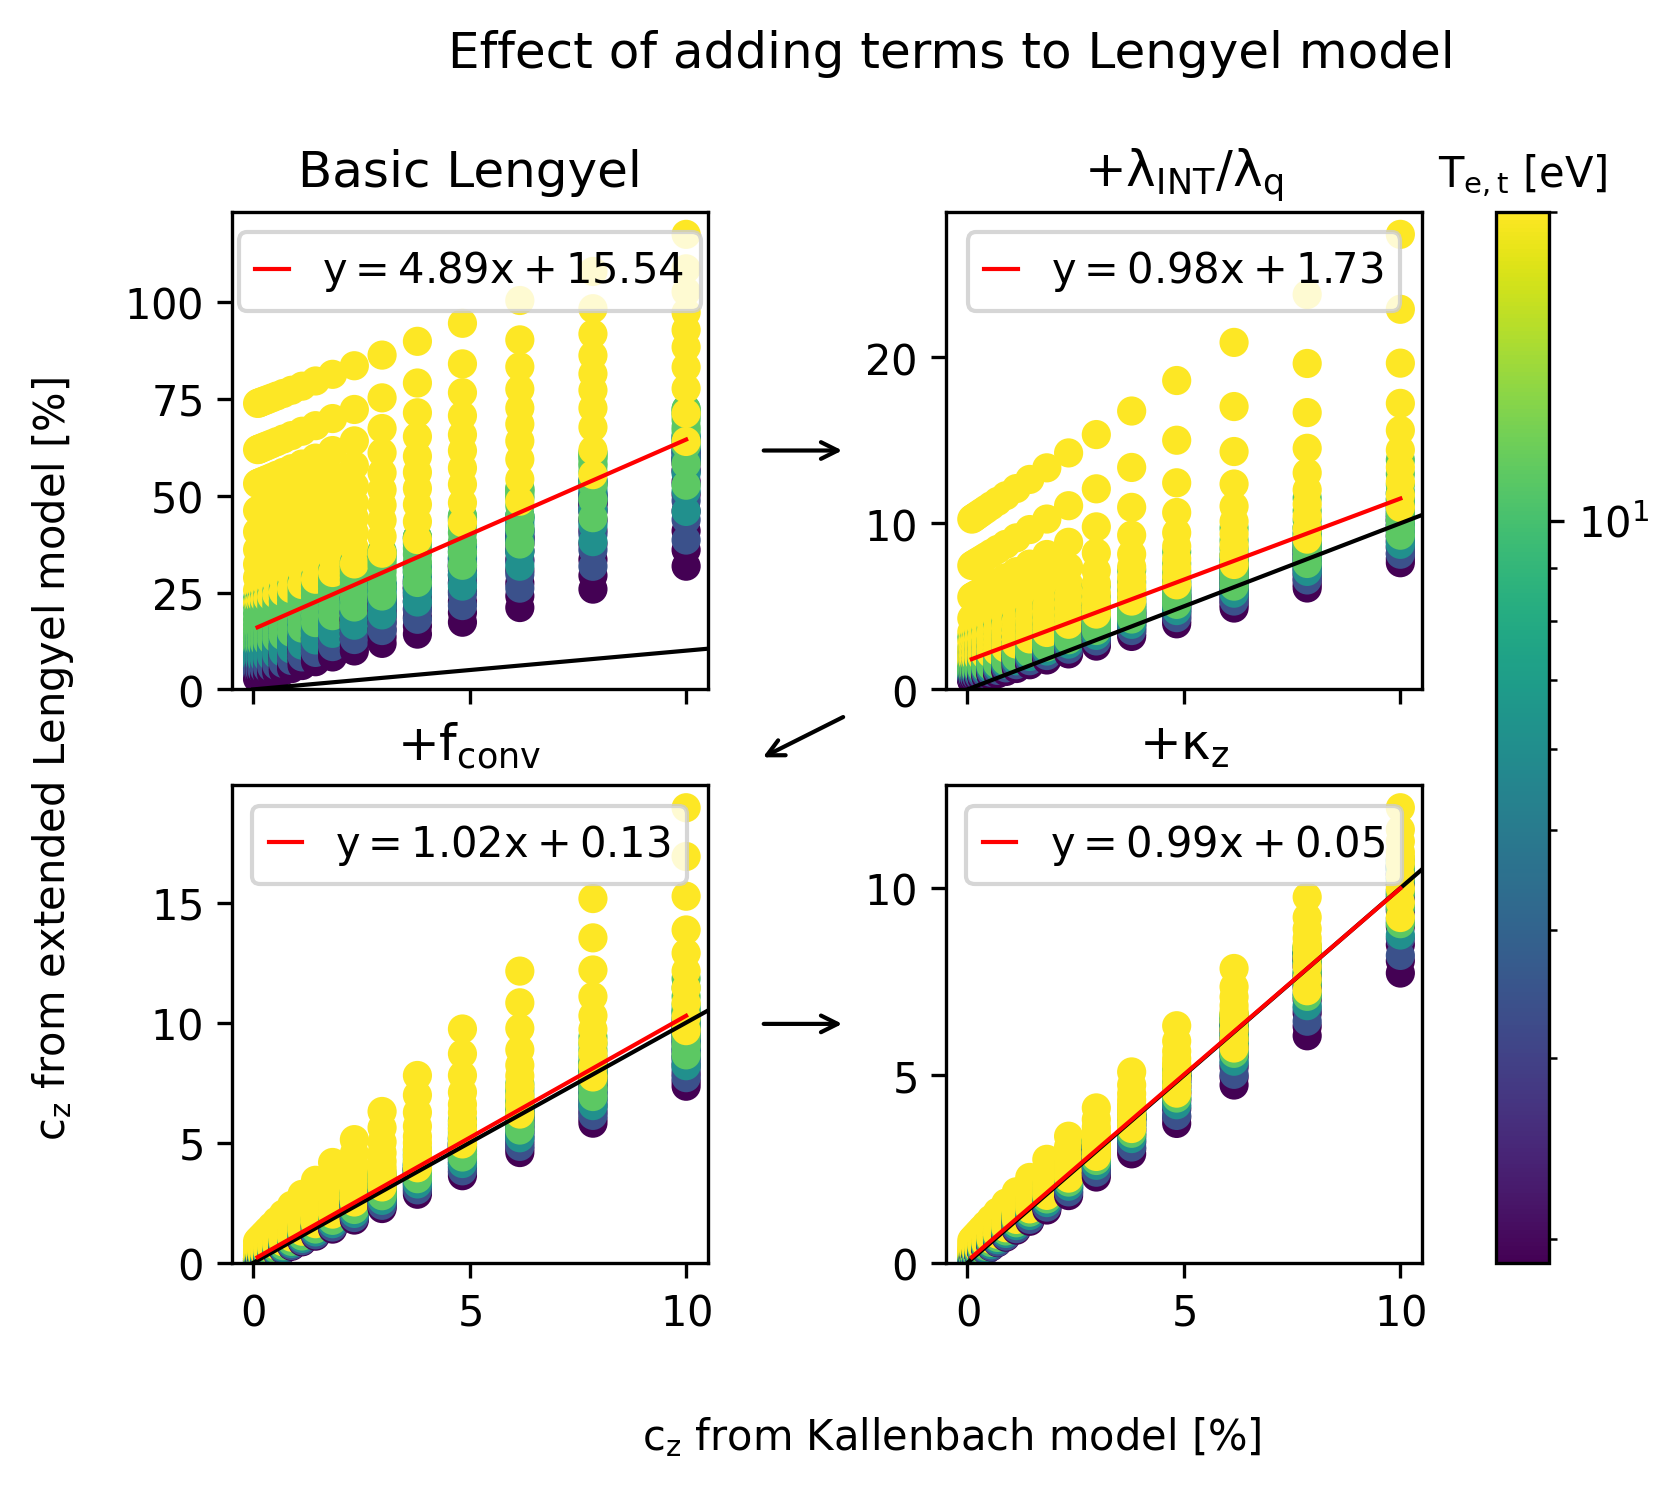

In [9]:
from scipy.optimize import curve_fit

def linear(x, m, b):
    """Simple linear fit."""
    return m * x + b

def linear_fit(x, y, info=True):
    """Fit a simple linear approximation to the data."""
    y = y.broadcast_like(x)
    popt, pcov = curve_fit(
        linear,
        xdata = x.where(~np.isnan(y), drop=True).values.flatten(),
        ydata = y.where(~np.isnan(y), drop=True).values.flatten(),
    )

    p_sigma = np.sqrt(np.diag(pcov))

    if info:
        print(f"Covariance matrix condition number: {np.linalg.cond(pcov)}, diagonal elements: {np.diag(pcov)}")
        print(
            f"gradient: {popt[0]:.6g} +/- {p_sigma[0]:.6g}\n"
            f"intercept: {popt[1]:.6g} +/- {p_sigma[1]:.6g}\n"
        )
    return lambda x: linear(x, *popt), f"$y={popt[0]:.2f}x+{popt[1]:.2f}$"

fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=False)
axs = axs.flatten()

variable_c = magnitude_in_units(reference_ds["target_electron_temp"], ureg.eV)
color_label = "$T_{e,t}$ [eV]"

for i, ds in enumerate([ds_basic, ds_S, ds_S_fconv, ds_S_fconv_Zeff]):

    x, y, c = xr.broadcast(
        magnitude_in_units(reference_ds["impurity_fraction"], ureg.percent),
        magnitude_in_units(ds["impurity_fraction"], ureg.percent),
        variable_c,
    )

    im = axs[i].scatter(np.ravel(x), np.ravel(y), c=np.ravel(c), norm=mpl.colors.LogNorm())
    axs[i].axline((0.0, 0.0), slope=1.0, color="k", linewidth=1.0)
    axs[i].set_ylim(bottom=0.0)

    fit, label = linear_fit(x, y)

    axs[i].plot(np.ravel(x), fit(np.ravel(x)), color="r", linewidth=1.0, label=label)
    axs[i].legend(fontsize=10, handlelength=0.8, loc="upper center")

small_fontsize = 10
large_fontsize = 12

fig.text(0.02, 0.5, "$c_z$ from extended Lengyel model [%]", fontsize=small_fontsize, va="center", rotation="vertical")
fig.text(0.5, 0.02, "$c_z$ from Kallenbach model [%]", ha="center", fontsize=small_fontsize)
fig.text(0.5, 0.98, "Effect of adding terms to Lengyel model", ha="center", fontsize=large_fontsize)

fig.subplots_adjust(wspace=0.5, bottom=0.15)
cbar = plt.colorbar(im, ax=axs)
cbar.ax.set_title(color_label, fontsize=10)

axs[0].set_title("Basic Lengyel")
axs[0].annotate('', xy=(1.3, 0.5), xycoords='axes fraction', xytext=(1.1, 0.5), arrowprops=dict(arrowstyle="->"))
axs[0].annotate('', xy=(1.3, -0.05), xycoords='axes fraction', xytext=(1.1, -0.15), arrowprops=dict(arrowstyle="<-"))
axs[1].set_title("$+\\lambda_{INT}/\\lambda_q$")
axs[2].set_title("$+ f_{conv}$")
axs[2].annotate('', xy=(1.3, 0.5), xycoords='axes fraction', xytext=(1.1, 0.5), arrowprops=dict(arrowstyle="->"))
axs[3].set_title("$+ \\kappa_z$")

fig.savefig(extended_lengyel.directories.output_dir / "lengyel_comparison.png", dpi=300, bbox_inches="tight")